# Setup Inicial

In [2]:
#Python Default 

import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

import pickle
import time
import random
import os
import inspect
import pathlib

#Essentials

import IPython
import numpy as np
from bs4 import BeautifulSoup
import requests
import func_timeout
import seaborn as sns
import pandas as pd
from itables import show
from scipy.optimize import curve_fit
from scipy import stats

#from objproxies import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objects as go

#Qiskit

from qiskit.circuit import Gate
from qiskit.circuit.library import *
from qiskit import transpile
from qiskit.providers.models import *
from qiskit_ibm_runtime.fake_provider import *
from qiskit.providers.fake_provider import *
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
from qiskit_aer import StatevectorSimulator
import qiskit_aer

## Qiskit Nature
    
from qiskit_nature.units import *   #ANGSTROM

from qiskit_nature.second_q.drivers import *    #PySCFDriver

from qiskit_nature.second_q.mappers import * #JordanWignerMapper

from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.problems import EigenstateResult

from qiskit_nature.second_q.circuit.library import *  #Ansatz, HF


## Qiskit Algorithms
    
from qiskit_algorithms.minimum_eigensolvers import VQE as  VQE_algorithms   #VQE
 
from qiskit_algorithms.optimizers import *    #SLSQP

from qiskit.circuit.library import EfficientSU2   #EfficientSU2

## Qiskit Estimators

from qiskit.primitives import Estimator as Estimator_Nature

from qiskit_aer.primitives.estimator import Estimator as Estimator_Aer

from qiskit_ibm_runtime import Estimator 

from qiskit_ibm_runtime import EstimatorV2

## Qiskit Noise Models

from qiskit_aer.noise import NoiseModel

from qiskit.providers.fake_provider import *

##Qiskit Runtime IBM

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options

## Braket

from braket.tracking import Tracker
from qiskit_braket_provider import *


%matplotlib widget
#%matplotlib inline

In [3]:
provider = BraketProvider()
local_simulator = BraketLocalBackend()
sv1 = provider.get_backend("SV1")
aria = provider.get_backend("Aria 1")
harmony = provider.get_backend("Harmony")
statevector_simulator = StatevectorSimulator()

In [4]:
print("Hello world")

Hello world


In [5]:
# Backends

provider = BraketProvider()
local_simulator = BraketLocalBackend()
sv1 = provider.get_backend("SV1")
aria = provider.get_backend("Aria 1")
harmony = provider.get_backend("Harmony")
statevector_simulator = StatevectorSimulator()

# Setup inicial do problema

driver = PySCFDriver(
    atom= f"H 0 0 0; H 0 0 1",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

#estimator = Estimator(backend = local_simulator, options={"shots" : 2000, "noise_model" : noise_model, "coupling_map" : coupling_map})

estimator = Estimator(backend = local_simulator)

mapper = JordanWignerMapper()

ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

vqe_solver = VQE_algorithms(estimator, ansatz, COBYLA())

vqe_solver.initial_point = [0.0] * ansatz.num_parameters

calc = GroundStateEigensolver(mapper, vqe_solver)

minimum_eigenvalue = vqe_solver.compute_minimum_eigenvalue(calc.get_qubit_operators(es_problem)[0])

# Criando Circuito Aria - AWS

circuito = transpile(minimum_eigenvalue.optimal_circuit.decompose().assign_parameters(minimum_eigenvalue.optimal_parameters), aria)

# Criando Circuito Brisbane - IBM

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
noise_model = NoiseModel.from_backend(backend)

circuito_ibm = transpile(minimum_eigenvalue.optimal_circuit.decompose().assign_parameters(minimum_eigenvalue.optimal_parameters), backend)

hamiltoniano = es_problem.second_q_ops()[0]

num_qubits_hamiltonian = JordanWignerMapper().map(hamiltoniano).num_qubits

new_circuit = QuantumCircuit(num_qubits_hamiltonian)

for gate in circuito_ibm.data:

    if all(circuito_ibm.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
        new_circuit.append(gate[0], [circuito_ibm.qubits.index(qubit) for qubit in gate[1]])

circuito_ibm = new_circuit

# Funções Globais

In [6]:
def get_current_directory():
    try:
        
        directory = os.path.dirname(os.path.abspath(__file__))

    except:
        
        ip = IPython.get_ipython()
        directory = None
        if '__vsc_ipynb_file__' in ip.user_ns:
            directory = os.path.dirname(ip.user_ns['__vsc_ipynb_file__'])
        
    return directory 


def salvar(a):
    
    script_dir = get_current_directory()
    
    dados_dir = os.path.join(script_dir, 'dados')
    
    os.makedirs(dados_dir, exist_ok=True)
    
    file_path = os.path.join(dados_dir, f'{a}.pickle')
    
    with open(file_path, 'wb') as f:
        pickle.dump(eval(a), f)

def abrir(a):
    
    script_dir = get_current_directory()
    
    file_path = os.path.join(script_dir, 'dados', f'{a}.pickle')
    
    with open(file_path, 'rb') as f:
        return pickle.load(f)

In [7]:

def run_statevector(circuit, driver, mapper = JordanWignerMapper()):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   estado = Statevector.from_instruction(circuit)
   
   expectation_value = estado.expectation_value(mapper.map(hamiltoniano))
   
   return expectation_value.real

def run_estimator(circuit, driver, backend = None, shots = 2000, noise_model = None, coupling_map = None, mapper = JordanWignerMapper()):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   new_circuit = circuit.copy()
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit
   
   if noise_model is not None:
      
      estimator = Estimator(backend = backend, options = {"shots" : shots, "noise_model" : noise_model, "coupling_map" : coupling_map})
   
   else :
      
      estimator = Estimator(backend = backend, options = {"shots" : shots})
   
   job = estimator.run(circuit, mapper.map(hamiltoniano))
   
   return job.result().values[0]

def run_estimator_aer(circuit, driver, shots = None, seed = None, mapper = JordanWignerMapper(), skip_transpilation = True):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   new_circuit = circuit.copy()
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit

   if shots != None:
   
      if seed is not None:
         
         estimator = Estimator_Aer(run_options = {"shots" : shots, "seed" : seed}, skip_transpilation = skip_transpilation)   
      
      else :
         
         estimator = Estimator_Aer(run_options = {"shots" : shots}, skip_transpilation = skip_transpilation)
   
   else :

      if seed is not None:
         
         estimator = Estimator_Aer(run_options = {"shots" : shots, "seed" : seed}, approximation = True, skip_transpilation = skip_transpilation)
      
      else :
         
         estimator = Estimator_Aer(run_options = {"shots" : shots}, approximation = True, skip_transpilation = skip_transpilation)
      
   
   job = estimator.run(circuit, mapper.map(hamiltoniano))
   
   return job.result().values[0]

def run_estimator_aer_noise(circuit, driver, shots = None, seed = None, mapper = JordanWignerMapper(), skip_transpilation = True, noise_model = None, coupling_map = None):
   
   hamiltoniano = driver.second_q_ops()[0]
   
   num_qubits_hamiltonian = mapper.map(hamiltoniano).num_qubits
   num_qubits_circuit = circuit.num_qubits
   
   new_circuit = circuit.copy()
   
   if num_qubits_hamiltonian != num_qubits_circuit:

      new_circuit = QuantumCircuit(num_qubits_hamiltonian)

      for gate in circuit.data:

         if all(circuit.qubits.index(qubit) < num_qubits_hamiltonian for qubit in gate[1]):
            new_circuit.append(gate[0], [circuit.qubits.index(qubit) for qubit in gate[1]])
   
   circuit = new_circuit
   
   estimator = Estimator_Aer(backend_options={'noise_model': noise_model}, run_options = {"shots" : shots, "seed" : seed}, skip_transpilation = skip_transpilation)         
   
   job = estimator.run(circuit, mapper.map(hamiltoniano))
   
   return job.result().values[0]

ESTIMATORS = {
    'statevector': run_statevector,
    'estimator': run_estimator,
    'estimator_aer': run_estimator_aer,
    'estimator_aer_noise': run_estimator_aer_noise,
}

def check(original_value, target, driver, difference_percentage, estimator_name='statevector', **kwargs):
    estimator_function = ESTIMATORS[estimator_name]
    target_value = estimator_function(target, driver, **kwargs)
    return abs(original_value - target_value) < difference_percentage * abs(original_value), target_value

# Importando Dados

In [8]:
def abrir_modelo(a):
    
    exec(f'modelo{a}_brisbane_3030_aer_2500 = abrir("modelo{a}_brisbane_3030_aer_2500")')
    exec(f'modelo{a}_brisbane_3030_simulator_2500 = abrir("modelo{a}_brisbane_3030_simulator_2500")')
    
    return eval(f'modelo{a}_brisbane_3030_aer_2500'), eval(f'modelo{a}_brisbane_3030_simulator_2500')

## Modelo 1

In [ ]:
modelo = 1

aer, simulator = abrir_modelo(modelo)

In [ ]:
original_expectation_value = run_estimator_aer(circuito_ibm, es_problem, seed = 1)
original_expectation_value_noisy = run_estimator_aer_noise(circuito_ibm, es_problem, shots = 2000, seed = 1, noise_model = noise_model)
original_gate_counts = {gate.name: sum(1 for g, *_ in circuito_ibm.data if g.name == gate.name) for gate, *_ in circuito_ibm.data}

original_circuit_dict = {
    'circuit': hex(id(circuito_ibm)) + ' (original)',
    'num_gates': circuito_ibm.size(),
    'gate_counts': dict(sorted(original_gate_counts.items(), key=lambda item: item[1], reverse=True)),
    'changed_gates': {gate: 0 for gate in original_gate_counts},
    'rz_gates': original_gate_counts.get('rz', 0),
    'expectation_value_exact': original_expectation_value,
    'expectation_value_noisy': original_expectation_value_noisy,
    'percentage_difference (%)': abs(abs(original_expectation_value_noisy - original_expectation_value) / original_expectation_value)* 100
}

data = [original_circuit_dict]

for index, a in enumerate(aer):
    circuit = a[0]
    expetation_value = a[1]
    row = {}
    row['circuit'] = hex(id(circuit))  
    row['circuit'] = hex(id(circuit))  
    row['num_gates'] = circuit.size()
    gate_counts = {gate.name: sum(1 for g, *_ in circuit.data if g.name == gate.name) for gate, *_ in circuit.data}
    row['gate_counts'] = dict(sorted(gate_counts.items(), key=lambda item: item[1], reverse=True))
    changed_gates = {gate: gate_counts.get(gate, 0) - original_gate_counts.get(gate, 0) for gate in set(gate_counts) | set(original_gate_counts)}
    row['changed_gates'] = dict(sorted(changed_gates.items(), key=lambda item: item[1], reverse=True))
    data.append(row)
    row['rz_gates'] = row['gate_counts'].get('rz', 0)  
    row['expectation_value_exact'] = expetation_value
    row['expectation_value_noisy'] = (noisy := simulator[index][1])
    row['percentage_difference (%)'] = abs(abs(noisy - expetation_value) / expetation_value)* 100

df_temp = pd.DataFrame(data)

show(df_temp)

In [ ]:
expected_values = df_temp['expectation_value_exact']

plt.figure()
plt.hist(list(expected_values), bins='auto', alpha=0.7, rwidth=0.85)
plt.axvline(original_expectation_value, color='r', linestyle='dotted', linewidth=2, label='Original Expectation Value')
plt.xlabel('Expected Value')
plt.ylabel('Frequency')
plt.title(f'Histogram of Expected Values - Modelo {modelo}')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
plt.figure()
plt.scatter(df_temp['expectation_value_exact'][1:], df_temp['expectation_value_noisy'][1:], label='Circuits', s = 2)
plt.scatter(df_temp.loc[0, 'expectation_value_exact'], df_temp.loc[0, 'expectation_value_noisy'], color='red', marker='*', s=100, label='Original Circuit')
plt.plot([min(df_temp['expectation_value_exact']), max(df_temp['expectation_value_exact'])], [min(df_temp['expectation_value_exact']), max(df_temp['expectation_value_exact'])], 'k--', label='y=x')
plt.xlabel('Exact Expectation Value')
plt.ylabel('Noisy Expectation Value')
plt.title(f'2500 Exact and Noisy Expectation Values - Modelo {modelo}')
plt.legend()
plt.show()

In [ ]:
popt, pcov = curve_fit((func := lambda x, a, b : a*x + b), df_temp['expectation_value_noisy'][1:], df_temp['expectation_value_exact'][1:])

plt.figure()
plt.scatter(df_temp['expectation_value_noisy'][1:], df_temp['expectation_value_exact'][1:], label='Circuits', s = 2)
plt.scatter(df_temp.loc[0, 'expectation_value_noisy'], df_temp.loc[0, 'expectation_value_exact'], color='red', marker='*', s=100, label='Original Circuit')
plt.plot((x := np.linspace(min(df_temp['expectation_value_noisy']), max(df_temp['expectation_value_noisy']), 100)), func(x, *popt), "r", label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.xlabel('Noisy Expectation Value')
plt.ylabel('Exact Expectation Value')
plt.title(f'2500 Exact and Noisy Expectation Values - Modelo {modelo}')
plt.legend()
plt.show()

In [ ]:
original = df_temp.loc[0, 'expectation_value_exact']
noisy = df_temp.loc[0, 'expectation_value_noisy']
corrected = func(noisy, *popt)
percentage = abs(abs(corrected - original) / original)* 100
percentage_noisy = abs(abs(corrected - noisy) / noisy)* 100

print(f"\nModelo {modelo} : \n\nOriginal Expectation Value: {original}\nNoisy Expectation Value: {noisy}\nCorrected Expectation Value: {corrected}\nPercentage Difference: {percentage}%\nPercentage Noisy Difference: {percentage_noisy}%")

## Modelo 2

In [ ]:
modelo = 2

aer, simulator = abrir_modelo(modelo)

In [ ]:
original_expectation_value = run_estimator_aer(circuito_ibm, es_problem, seed = 1)
original_expectation_value_noisy = run_estimator_aer_noise(circuito_ibm, es_problem, shots = 2000, seed = 1, noise_model = noise_model)
original_gate_counts = {gate.name: sum(1 for g, *_ in circuito_ibm.data if g.name == gate.name) for gate, *_ in circuito_ibm.data}

original_circuit_dict = {
    'circuit': hex(id(circuito_ibm)) + ' (original)',
    'num_gates': circuito_ibm.size(),
    'gate_counts': dict(sorted(original_gate_counts.items(), key=lambda item: item[1], reverse=True)),
    'changed_gates': {gate: 0 for gate in original_gate_counts},
    'rz_gates': original_gate_counts.get('rz', 0),
    'expectation_value_exact': original_expectation_value,
    'expectation_value_noisy': original_expectation_value_noisy,
    'percentage_difference (%)': abs(abs(original_expectation_value_noisy - original_expectation_value) / original_expectation_value)* 100
}

data = [original_circuit_dict]

for index, a in enumerate(aer):
    circuit = a[0]
    expetation_value = a[1]
    row = {}
    row['circuit'] = hex(id(circuit))  
    row['circuit'] = hex(id(circuit))  
    row['num_gates'] = circuit.size()
    gate_counts = {gate.name: sum(1 for g, *_ in circuit.data if g.name == gate.name) for gate, *_ in circuit.data}
    row['gate_counts'] = dict(sorted(gate_counts.items(), key=lambda item: item[1], reverse=True))
    changed_gates = {gate: gate_counts.get(gate, 0) - original_gate_counts.get(gate, 0) for gate in set(gate_counts) | set(original_gate_counts)}
    row['changed_gates'] = dict(sorted(changed_gates.items(), key=lambda item: item[1], reverse=True))
    data.append(row)
    row['rz_gates'] = row['gate_counts'].get('rz', 0)  
    row['expectation_value_exact'] = expetation_value
    row['expectation_value_noisy'] = (noisy := simulator[index][1])
    row['percentage_difference (%)'] = abs(abs(noisy - expetation_value) / expetation_value)* 100

df_temp = pd.DataFrame(data)

show(df_temp)

In [ ]:
expected_values = df_temp['expectation_value_exact']

plt.figure()
plt.hist(list(expected_values), bins='auto', alpha=0.7, rwidth=0.85)
plt.axvline(original_expectation_value, color='r', linestyle='dotted', linewidth=2, label='Original Expectation Value')
plt.xlabel('Expected Value')
plt.ylabel('Frequency')
plt.title(f'Histogram of Expected Values - Modelo {modelo}')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
plt.figure()
plt.scatter(df_temp['expectation_value_exact'][1:], df_temp['expectation_value_noisy'][1:], label='Circuits', s = 2)
plt.scatter(df_temp.loc[0, 'expectation_value_exact'], df_temp.loc[0, 'expectation_value_noisy'], color='red', marker='*', s=100, label='Original Circuit')
plt.plot([min(df_temp['expectation_value_exact']), max(df_temp['expectation_value_exact'])], [min(df_temp['expectation_value_exact']), max(df_temp['expectation_value_exact'])], 'k--', label='y=x')
plt.xlabel('Exact Expectation Value')
plt.ylabel('Noisy Expectation Value')
plt.title(f'2500 Exact and Noisy Expectation Values - Modelo {modelo}')
plt.legend()
plt.show()

In [ ]:
popt, pcov = curve_fit((func := lambda x, a, b : a*x + b), df_temp['expectation_value_noisy'][1:], df_temp['expectation_value_exact'][1:])

plt.figure()
plt.scatter(df_temp['expectation_value_noisy'][1:], df_temp['expectation_value_exact'][1:], label='Circuits', s = 2)
plt.scatter(df_temp.loc[0, 'expectation_value_noisy'], df_temp.loc[0, 'expectation_value_exact'], color='red', marker='*', s=100, label='Original Circuit')
plt.plot((x := np.linspace(min(df_temp['expectation_value_noisy']), max(df_temp['expectation_value_noisy']), 100)), func(x, *popt), "r", label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.xlabel('Noisy Expectation Value')
plt.ylabel('Exact Expectation Value')
plt.title(f'2500 Exact and Noisy Expectation Values - Modelo {modelo}')
plt.legend()
plt.show()

In [ ]:
original = df_temp.loc[0, 'expectation_value_exact']
noisy = df_temp.loc[0, 'expectation_value_noisy']
corrected = func(noisy, *popt)
percentage = abs(abs(corrected - original) / original)* 100
percentage_noisy = abs(abs(corrected - noisy) / noisy)* 100

print(f"\nModelo {modelo} : \n\nOriginal Expectation Value: {original}\nNoisy Expectation Value: {noisy}\nCorrected Expectation Value: {corrected}\nPercentage Difference: {percentage}%\nPercentage Noisy Difference: {percentage_noisy}%")

## Modelo 3

In [ ]:
modelo = 3

aer, simulator = abrir_modelo(modelo)

In [ ]:
original_expectation_value = run_estimator_aer(circuito_ibm, es_problem, seed = 1)
original_expectation_value_noisy = run_estimator_aer_noise(circuito_ibm, es_problem, shots = 2000, seed = 1, noise_model = noise_model)
original_gate_counts = {gate.name: sum(1 for g, *_ in circuito_ibm.data if g.name == gate.name) for gate, *_ in circuito_ibm.data}

original_circuit_dict = {
    'circuit': hex(id(circuito_ibm)) + ' (original)',
    'num_gates': circuito_ibm.size(),
    'gate_counts': dict(sorted(original_gate_counts.items(), key=lambda item: item[1], reverse=True)),
    'changed_gates': {gate: 0 for gate in original_gate_counts},
    'rz_gates': original_gate_counts.get('rz', 0),
    'expectation_value_exact': original_expectation_value,
    'expectation_value_noisy': original_expectation_value_noisy,
    'percentage_difference (%)': abs(abs(original_expectation_value_noisy - original_expectation_value) / original_expectation_value)* 100
}

data = [original_circuit_dict]

for index, a in enumerate(aer):
    circuit = a[0]
    expetation_value = a[1]
    row = {}
    row['circuit'] = hex(id(circuit))  
    row['circuit'] = hex(id(circuit))  
    row['num_gates'] = circuit.size()
    gate_counts = {gate.name: sum(1 for g, *_ in circuit.data if g.name == gate.name) for gate, *_ in circuit.data}
    row['gate_counts'] = dict(sorted(gate_counts.items(), key=lambda item: item[1], reverse=True))
    changed_gates = {gate: gate_counts.get(gate, 0) - original_gate_counts.get(gate, 0) for gate in set(gate_counts) | set(original_gate_counts)}
    row['changed_gates'] = dict(sorted(changed_gates.items(), key=lambda item: item[1], reverse=True))
    data.append(row)
    row['rz_gates'] = row['gate_counts'].get('rz', 0)  
    row['expectation_value_exact'] = expetation_value
    row['expectation_value_noisy'] = (noisy := simulator[index][1])
    row['percentage_difference (%)'] = abs(abs(noisy - expetation_value) / expetation_value)* 100

df_temp = pd.DataFrame(data)

show(df_temp)

In [ ]:
expected_values = df_temp['expectation_value_exact']

plt.figure()
plt.hist(list(expected_values), bins='auto', alpha=0.7, rwidth=0.85)
plt.axvline(original_expectation_value, color='r', linestyle='dotted', linewidth=2, label='Original Expectation Value')
plt.xlabel('Expected Value')
plt.ylabel('Frequency')
plt.title(f'Histogram of Expected Values - Modelo {modelo}')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
plt.figure()
plt.scatter(df_temp['expectation_value_exact'][1:], df_temp['expectation_value_noisy'][1:], label='Circuits', s = 2)
plt.scatter(df_temp.loc[0, 'expectation_value_exact'], df_temp.loc[0, 'expectation_value_noisy'], color='red', marker='*', s=100, label='Original Circuit')
plt.plot([min(df_temp['expectation_value_exact']), max(df_temp['expectation_value_exact'])], [min(df_temp['expectation_value_exact']), max(df_temp['expectation_value_exact'])], 'k--', label='y=x')
plt.xlabel('Exact Expectation Value')
plt.ylabel('Noisy Expectation Value')
plt.title(f'2500 Exact and Noisy Expectation Values - Modelo {modelo}')
plt.legend()
plt.show()

In [ ]:
popt, pcov = curve_fit((func := lambda x, a, b : a*x + b), df_temp['expectation_value_noisy'][1:], df_temp['expectation_value_exact'][1:])

plt.figure()
plt.scatter(df_temp['expectation_value_noisy'][1:], df_temp['expectation_value_exact'][1:], label='Circuits', s = 2)
plt.scatter(df_temp.loc[0, 'expectation_value_noisy'], df_temp.loc[0, 'expectation_value_exact'], color='red', marker='*', s=100, label='Original Circuit')
plt.plot((x := np.linspace(min(df_temp['expectation_value_noisy']), max(df_temp['expectation_value_noisy']), 100)), func(x, *popt), "r", label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.xlabel('Noisy Expectation Value')
plt.ylabel('Exact Expectation Value')
plt.title(f'2500 Exact and Noisy Expectation Values - Modelo {modelo}')
plt.legend()
plt.show()

In [ ]:
original = df_temp.loc[0, 'expectation_value_exact']
noisy = df_temp.loc[0, 'expectation_value_noisy']
corrected = func(noisy, *popt)
percentage = abs(abs(corrected - original) / original)* 100
percentage_noisy = abs(abs(corrected - noisy) / noisy)* 100

print(f"\nModelo {modelo} : \n\nOriginal Expectation Value: {original}\nNoisy Expectation Value: {noisy}\nCorrected Expectation Value: {corrected}\nPercentage Difference: {percentage}%\nPercentage Noisy Difference: {percentage_noisy}%")

## Modelo 4

In [ ]:
modelo = 4

aer, simulator = abrir_modelo(modelo)

In [ ]:
original_expectation_value = run_estimator_aer(circuito_ibm, es_problem, seed = 1)
original_expectation_value_noisy = run_estimator_aer_noise(circuito_ibm, es_problem, shots = 2000, seed = 1, noise_model = noise_model)
original_gate_counts = {gate.name: sum(1 for g, *_ in circuito_ibm.data if g.name == gate.name) for gate, *_ in circuito_ibm.data}

original_circuit_dict = {
    'circuit': hex(id(circuito_ibm)) + ' (original)',
    'num_gates': circuito_ibm.size(),
    'gate_counts': dict(sorted(original_gate_counts.items(), key=lambda item: item[1], reverse=True)),
    'changed_gates': {gate: 0 for gate in original_gate_counts},
    'rz_gates': original_gate_counts.get('rz', 0),
    'expectation_value_exact': original_expectation_value,
    'expectation_value_noisy': original_expectation_value_noisy,
    'percentage_difference (%)': abs(abs(original_expectation_value_noisy - original_expectation_value) / original_expectation_value)* 100
}

data = [original_circuit_dict]

for index, a in enumerate(aer):
    circuit = a[0]
    expetation_value = a[1]
    row = {}
    row['circuit'] = hex(id(circuit))  
    row['circuit'] = hex(id(circuit))  
    row['num_gates'] = circuit.size()
    gate_counts = {gate.name: sum(1 for g, *_ in circuit.data if g.name == gate.name) for gate, *_ in circuit.data}
    row['gate_counts'] = dict(sorted(gate_counts.items(), key=lambda item: item[1], reverse=True))
    changed_gates = {gate: gate_counts.get(gate, 0) - original_gate_counts.get(gate, 0) for gate in set(gate_counts) | set(original_gate_counts)}
    row['changed_gates'] = dict(sorted(changed_gates.items(), key=lambda item: item[1], reverse=True))
    data.append(row)
    row['rz_gates'] = row['gate_counts'].get('rz', 0)  
    row['expectation_value_exact'] = expetation_value
    row['expectation_value_noisy'] = (noisy := simulator[index][1])
    row['percentage_difference (%)'] = abs(abs(noisy - expetation_value) / expetation_value)* 100

df_temp = pd.DataFrame(data)

show(df_temp)

In [ ]:
expected_values = df_temp['expectation_value_exact']

plt.figure()
plt.hist(list(expected_values), bins='auto', alpha=0.7, rwidth=0.85)
plt.axvline(original_expectation_value, color='r', linestyle='dotted', linewidth=2, label='Original Expectation Value')
plt.xlabel('Expected Value')
plt.ylabel('Frequency')
plt.title(f'Histogram of Expected Values - Modelo {modelo}')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
plt.figure()
plt.scatter(df_temp['expectation_value_exact'][1:], df_temp['expectation_value_noisy'][1:], label='Circuits', s = 2)
plt.scatter(df_temp.loc[0, 'expectation_value_exact'], df_temp.loc[0, 'expectation_value_noisy'], color='red', marker='*', s=100, label='Original Circuit')
plt.plot([min(df_temp['expectation_value_exact']), max(df_temp['expectation_value_exact'])], [min(df_temp['expectation_value_exact']), max(df_temp['expectation_value_exact'])], 'k--', label='y=x')
plt.xlabel('Exact Expectation Value')
plt.ylabel('Noisy Expectation Value')
plt.title(f'2500 Exact and Noisy Expectation Values - Modelo {modelo}')
plt.legend()
plt.show()

In [ ]:
popt, pcov = curve_fit((func := lambda x, a, b : a*x + b), df_temp['expectation_value_noisy'][1:], df_temp['expectation_value_exact'][1:])

plt.figure()
plt.scatter(df_temp['expectation_value_noisy'][1:], df_temp['expectation_value_exact'][1:], label='Circuits', s = 2)
plt.scatter(df_temp.loc[0, 'expectation_value_noisy'], df_temp.loc[0, 'expectation_value_exact'], color='red', marker='*', s=100, label='Original Circuit')
plt.plot((x := np.linspace(min(df_temp['expectation_value_noisy']), max(df_temp['expectation_value_noisy']), 100)), func(x, *popt), "r", label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.xlabel('Noisy Expectation Value')
plt.ylabel('Exact Expectation Value')
plt.title(f'2500 Exact and Noisy Expectation Values - Modelo {modelo}')
plt.legend()
plt.show()

In [ ]:
original = df_temp.loc[0, 'expectation_value_exact']
noisy = df_temp.loc[0, 'expectation_value_noisy']
corrected = func(noisy, *popt)
percentage = abs(abs(corrected - original) / original)* 100
percentage_noisy = abs(abs(corrected - noisy) / noisy)* 100

print(f"\nModelo {modelo} : \n\nOriginal Expectation Value: {original}\nNoisy Expectation Value: {noisy}\nCorrected Expectation Value: {corrected}\nPercentage Difference: {percentage}%\nPercentage Noisy Difference: {percentage_noisy}%")

# Analisando quantidade minima de QC

In [9]:
modelo = 1

aer, simulator = abrir_modelo(modelo)

In [10]:
original_expectation_value = run_estimator_aer(circuito_ibm, es_problem, seed = 1)
original_expectation_value_noisy = run_estimator_aer_noise(circuito_ibm, es_problem, shots = 2000, seed = 1, noise_model = noise_model)
original_gate_counts = {gate.name: sum(1 for g, *_ in circuito_ibm.data if g.name == gate.name) for gate, *_ in circuito_ibm.data}

original_circuit_dict = {
    'circuit': hex(id(circuito_ibm)) + ' (original)',
    'num_gates': circuito_ibm.size(),
    'gate_counts': dict(sorted(original_gate_counts.items(), key=lambda item: item[1], reverse=True)),
    'changed_gates': {gate: 0 for gate in original_gate_counts},
    'rz_gates': original_gate_counts.get('rz', 0),
    'expectation_value_exact': original_expectation_value,
    'expectation_value_noisy': original_expectation_value_noisy,
    'percentage_difference (%)': abs(abs(original_expectation_value_noisy - original_expectation_value) / original_expectation_value)* 100
}

data = [original_circuit_dict]

for index, a in enumerate(aer):
    circuit = a[0]
    expetation_value = a[1]
    row = {}
    row['circuit'] = hex(id(circuit))  
    row['circuit'] = hex(id(circuit))  
    row['num_gates'] = circuit.size()
    gate_counts = {gate.name: sum(1 for g, *_ in circuit.data if g.name == gate.name) for gate, *_ in circuit.data}
    row['gate_counts'] = dict(sorted(gate_counts.items(), key=lambda item: item[1], reverse=True))
    changed_gates = {gate: gate_counts.get(gate, 0) - original_gate_counts.get(gate, 0) for gate in set(gate_counts) | set(original_gate_counts)}
    row['changed_gates'] = dict(sorted(changed_gates.items(), key=lambda item: item[1], reverse=True))
    data.append(row)
    row['rz_gates'] = row['gate_counts'].get('rz', 0)  
    row['expectation_value_exact'] = expetation_value
    row['expectation_value_noisy'] = (noisy := simulator[index][1])
    row['percentage_difference (%)'] = abs(abs(noisy - expetation_value) / expetation_value)* 100

df_temp = pd.DataFrame(data)

show(df_temp)

In [11]:
df_temp = df_temp[1:]

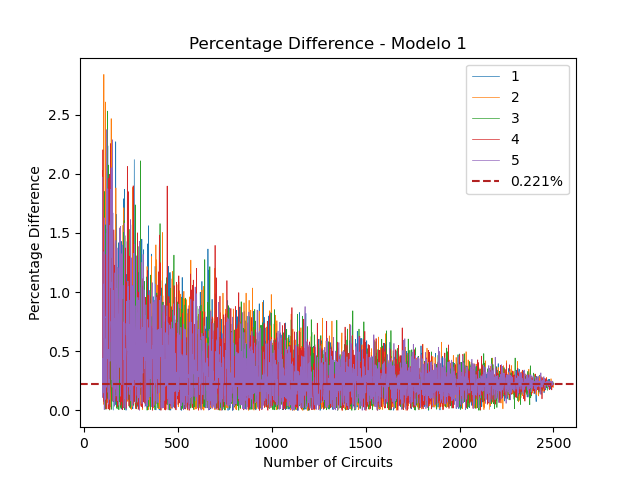

In [12]:

original = -1.626061535431763
noisy = -1.3859797971164516

dados_x = range(100, len(df_temp.index))

plt.figure()

for a in range(1, 6):

    percentages = []

    for i in dados_x:
        
        random_indices = random.sample(list(df_temp.index), i)
        
        popt, pcov = curve_fit((func := lambda x, a, b : a*x + b), df_temp['expectation_value_noisy'][random_indices], df_temp['expectation_value_exact'][random_indices])
        
        corrected = func(noisy, *popt)

        percentages.append(abs(abs(corrected - original) / original)* 100)
        
    plt.plot(dados_x, percentages, linewidth=0.5, label = f'{a}')

plt.axhline(y=0.221, color='firebrick', linestyle='--', label = '0.221%')
plt.xlabel('Number of Circuits')
#plt.xscale('log')
plt.ylabel('Percentage Difference')
plt.title(f'Percentage Difference - Modelo {modelo}')
plt.legend()
plt.show()


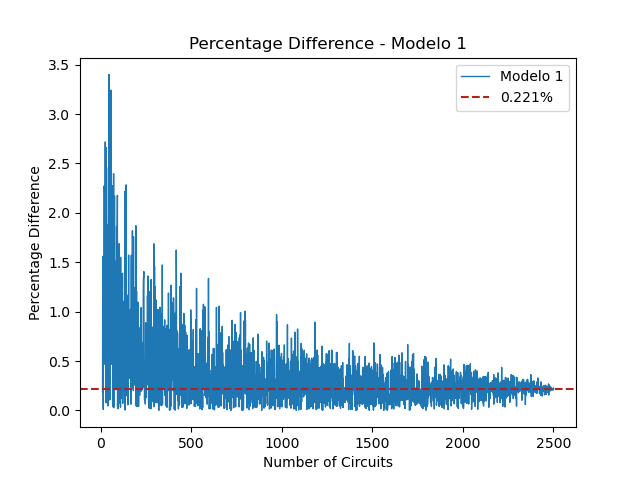

In [13]:

dados_x = range(10, len(df_temp.index))

plt.figure()

percentages = []

for i in dados_x:
    
    random_indices = random.sample(list(df_temp.index), i)
    
    popt, pcov = curve_fit((func := lambda x, a, b : a*x + b), df_temp['expectation_value_noisy'][random_indices], df_temp['expectation_value_exact'][random_indices])
    
    corrected = func(noisy, *popt)

    percentages.append(abs(abs(corrected - original) / original)* 100)
    
plt.plot(dados_x, percentages, linewidth=1, label = f'Modelo 1')

plt.axhline(y=0.221, color='firebrick', linestyle='--', label = '0.221%')
plt.xlabel('Number of Circuits')
plt.ylabel('Percentage Difference')
plt.title(f'Percentage Difference - Modelo {modelo}')
plt.legend()
plt.show()

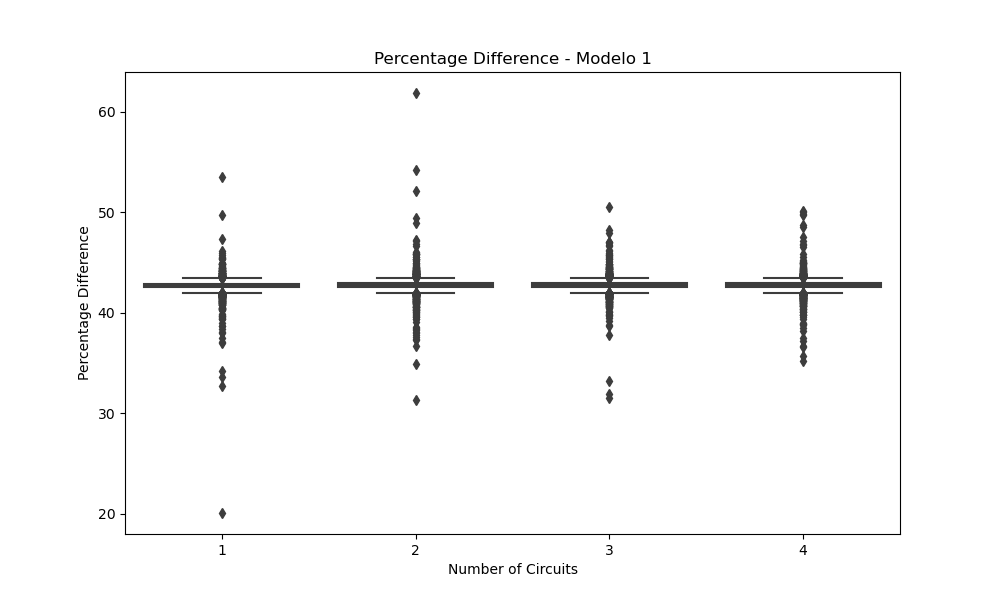

In [14]:
dados_x = range(3, len(df_temp.index))
percentages_dict = {}

for a in range(1, 5):
    percentages = []
    for i in dados_x:
        random_indices = random.sample(list(df_temp.index), i)
        popt, pcov = curve_fit(lambda x, a, b: a*x + b, df_temp['expectation_value_noisy'][random_indices], df_temp['expectation_value_exact'][random_indices])
        corrected = func(noisy, *popt)
        percentages.append(abs(abs(corrected - expetation_value) / expetation_value) * 100)
    percentages_dict[f'{a}'] = percentages

df_percentages = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in percentages_dict.items()]))

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_percentages)

plt.xlabel('Number of Circuits')
plt.ylabel('Percentage Difference')
plt.title(f'Percentage Difference - Modelo {modelo}')
plt.show()

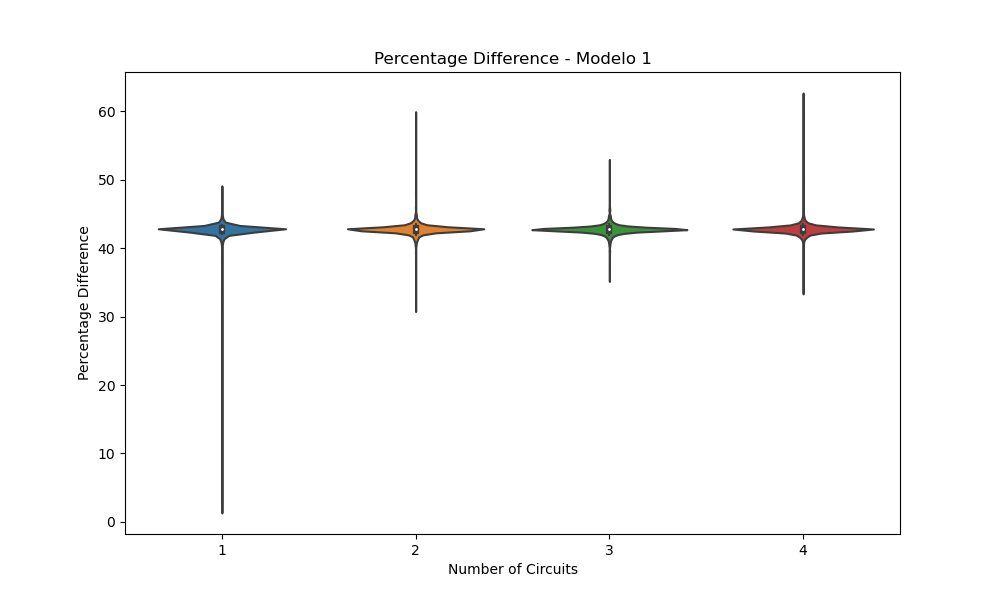

In [15]:
dados_x = range(3, len(df_temp.index))
percentages_dict = {}

for a in range(1, 5):
    percentages = []
    for i in dados_x:
        random_indices = random.sample(list(df_temp.index), i)
        popt, pcov = curve_fit(lambda x, a, b: a*x + b, df_temp['expectation_value_noisy'][random_indices], df_temp['expectation_value_exact'][random_indices])
        corrected = func(noisy, *popt)
        percentages.append(abs(abs(corrected - expetation_value) / expetation_value) * 100)
    percentages_dict[f'{a}'] = percentages

df_percentages = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in percentages_dict.items()]))

plt.figure(figsize=(10, 6))
sns.violinplot(data=df_percentages)

plt.xlabel('Number of Circuits')
plt.ylabel('Percentage Difference')
plt.title(f'Percentage Difference - Modelo {modelo}')
plt.show()

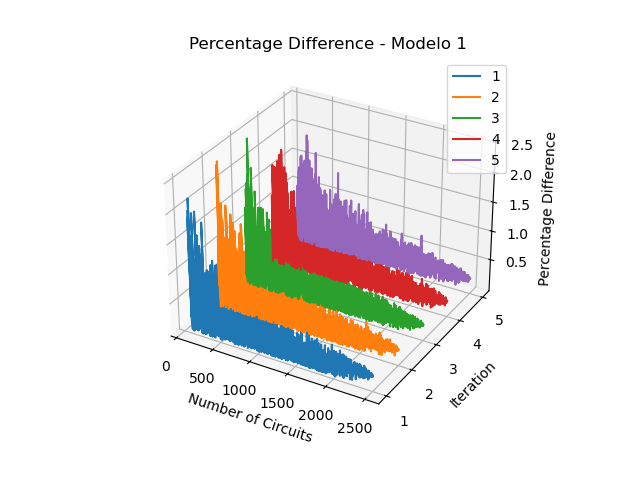

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

dados_x = np.array(range(100, len(df_temp.index)))

for a in range(1, 6):
    percentages = []

    for i in dados_x:
        random_indices = random.sample(list(df_temp.index), i)
        popt, pcov = curve_fit(lambda x, a, b: a*x + b, df_temp['expectation_value_noisy'][random_indices], df_temp['expectation_value_exact'][random_indices])
        corrected = func(noisy, *popt)
        percentages.append(abs(abs(corrected - original) / original) * 100)

    ax.plot(dados_x, percentages, zs=a, zdir='y', label=f'{a}')

ax.set_xlabel('Number of Circuits')
ax.set_ylabel('Iteration')
ax.set_zlabel('Percentage Difference')
ax.set_title(f'Percentage Difference - Modelo {modelo}')
ax.legend()

plt.show()

In [17]:
dados_x = np.array(range(100, len(df_temp.index)))
fig = go.Figure()

for a in range(1, 6):
    percentages = []

    for i in dados_x:
        random_indices = random.sample(list(df_temp.index), i)
        popt, pcov = curve_fit(lambda x, a, b: a*x + b, df_temp['expectation_value_noisy'][random_indices], df_temp['expectation_value_exact'][random_indices])
        corrected = func(noisy, *popt)
        percentages.append(abs(abs(corrected - original) / original) * 100)

    fig.add_trace(go.Scatter3d(x=dados_x, y=[a]*len(dados_x), z=percentages, mode='lines', name=f'Iteration {a}'))

fig.update_layout(title=f'Percentage Difference - Modelo {modelo}',
                  scene=dict(
                      xaxis_title='Number of Circuits',
                      yaxis_title='Iteration',
                      zaxis_title='Percentage Difference'
                  ),
                  legend_title="Iterations")

fig.show()

In [18]:
fig.write_html('plot3d.html')

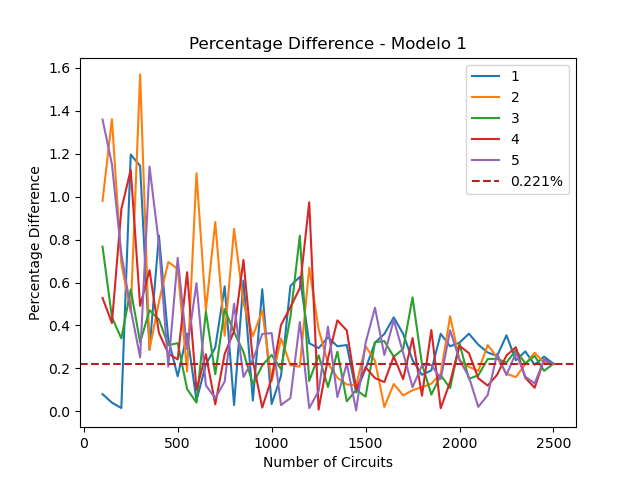

In [19]:
dados_x = range(100, len(df_temp.index))

plt.figure()

for a in range(1, 6):

    percentages = []

    for i in (dados_temp := dados_x[::50]):
        
        random_indices = random.sample(list(df_temp.index), i)
        
        popt, pcov = curve_fit((func := lambda x, a, b : a*x + b), df_temp['expectation_value_noisy'][random_indices], df_temp['expectation_value_exact'][random_indices])
        
        corrected = func(noisy, *popt)

        percentages.append(abs(abs(corrected - original) / original)* 100)
        
    plt.plot(dados_temp, percentages, label = f'{a}')

plt.axhline(y=0.221, color='firebrick', linestyle='--', label = '0.221%')
plt.xlabel('Number of Circuits')
#plt.xscale('log')
plt.ylabel('Percentage Difference')
plt.title(f'Percentage Difference - Modelo {modelo}')
plt.legend()
plt.show()

In [20]:
dados_x = range(100, len(df_temp.index))

percentage = []

for a in range(1, 30):

    percentages = []

    for i in dados_x:
        
        random_indices = random.sample(list(df_temp.index), i)
        
        popt, pcov = curve_fit((func := lambda x, a, b : a*x + b), df_temp['expectation_value_noisy'][random_indices], df_temp['expectation_value_exact'][random_indices])
        
        corrected = func(noisy, *popt)

        percentages.append(abs(abs(corrected - original) / original)* 100)

    percentage.append(percentages)

In [21]:
df_percentage = pd.DataFrame(percentage)

df_percentage

0         1         2         3         4         5         6     \
0   1.750125  0.502559  0.571385  0.363091  1.929990  0.881964  0.709906   
1   1.140304  1.282288  1.046180  0.120032  0.274685  0.045681  0.752416   
2   1.608591  1.520765  0.592091  1.216825  0.285728  1.282515  1.300201   
3   0.788325  0.479555  1.496975  1.013437  1.315989  2.344811  1.148894   
4   0.444987  1.420514  1.189837  0.034241  0.861734  0.712792  0.741736   
5   0.718278  0.630150  0.112277  0.021656  0.995153  1.358813  0.370461   
6   0.503750  2.373170  1.239062  2.651371  2.309231  1.349236  0.167712   
7   0.471504  0.054372  0.612471  0.191069  0.166158  0.200715  1.635313   
8   0.759722  1.331529  0.874128  0.811994  0.708184  1.944355  0.229474   
9   0.993298  0.332720  1.900633  1.060267  0.908293  0.579107  0.775851   
10  0.631975  0.103409  0.343474  0.024039  0.978127  0.575784  0.719718   
11  0.801725  2.834156  0.313822  1.401353  0.862211  0.268283  0.088700   
12  1.517535  0.248289  1.403907  0.510389  0.431100  0.714303  0.365124   
13  0.243197  3.673215  2.080670  0.871924  0.195002  1.370114  0.921964   
14  0.254985  1.201475  0.298773  1.386767  1.873915  1.827525  0.174452   
15  1.130631  1.154637  0.382985  0.663591  1.562817  0.741724  0.069456   
16  1.368706  0.488604  0.696555  0.413261  0.207697  1.567399  1.942643   
17  0.302277  1.632442  0.914145  0.150538  0.006068  0.543027  0.256694   
18  0.234840  1.069098  1.453840  1.006731  1.543648  0.666338  3.305372   
19  0.102104  2.651381  0.726380  0.620655  0.431001  1.765119  0.210531   
20  0.040174  0.010077  0.995166  1.150739  1.591197  0.441989  0.687152   
21  0.733512  0.075073  0.727933  1.906352  1.047884  1.223184  0.066246   
22  1.468225  1.240774  0.827031  0.931394  0.645903  1.140634  1.360149   
23  0.603746  0.364940  0.726072  0.575317  0.899299  0.904425  0.701039   
24  1.183979  0.858185  0.419971  0.114688  0.134345  0.577729  2.722086   
25  0.428390  1.821146  0.007446  0.224448  0.533889  0.040301  0.294297   
26  0.934796  1.998928  0.587870  0.490222  1.354100  1.126917  0.331781   
27  0.502529  0.320964  0.100642  1.850340  0.172674  0.048105  0.091199   
28  0.694288  0.630170  0.007273  0.790715  1.111849  0.367362  0.519682   

        7         8         9     ...      2391      2392      2393      2394  \
0   0.508591  0.845437  1.249902  ...  0.225371  0.194380  0.217645  0.225003   
1   0.576250  0.131760  0.283108  ...  0.239527  0.227560  0.225195  0.221032   
2   1.210388  1.098605  0.968155  ...  0.226620  0.221915  0.220426  0.202995   
3   2.029079  0.036631  0.219852  ...  0.226442  0.208220  0.223704  0.223732   
4   0.059043  1.188644  1.153363  ...  0.203075  0.218523  0.226345  0.220063   
5   0.920317  1.759044  1.085383  ...  0.217534  0.217810  0.217313  0.211849   
6   1.488864  2.053944  0.028198  ...  0.217294  0.205603  0.216118  0.219150   
7   0.576171  0.238688  0.611394  ...  0.242127  0.220328  0.224625  0.220512   
8   0.123515  0.548735  0.989631  ...  0.225514  0.229954  0.216034  0.209762   
9   0.700215  0.598684  1.255759  ...  0.226441  0.224299  0.214133  0.228291   
10  2.335938  0.171972  0.763171  ...  0.227844  0.228522  0.222813  0.220521   
11  1.982033  1.001283  0.509659  ...  0.202396  0.221539  0.235229  0.234542   
12  0.063917  0.352192  0.159283  ...  0.214662  0.221288  0.221199  0.178388   
13  0.378025  1.136773  0.075372  ...  0.201388  0.178070  0.238237  0.197632   
14  0.341465  0.778691  0.653602  ...  0.232792  0.206735  0.225580  0.229717   
15  0.507984  0.355997  0.067551  ...  0.221509  0.221207  0.223891  0.238252   
16  0.786290  1.036263  0.708720  ...  0.230136  0.227949  0.191847  0.215497   
17  0.188800  0.167234  0.264701  ...  0.234329  0.233827  0.201541  0.198191   
18  0.989140  0.610264  0.333806  ...  0.226755  0.217022  0.217930  0.228536   
19  0.663997  1.571917  0.554445  ...  0.226481  0.190133  0.202025  0.211546   
20  0.036399  0.230037  0.

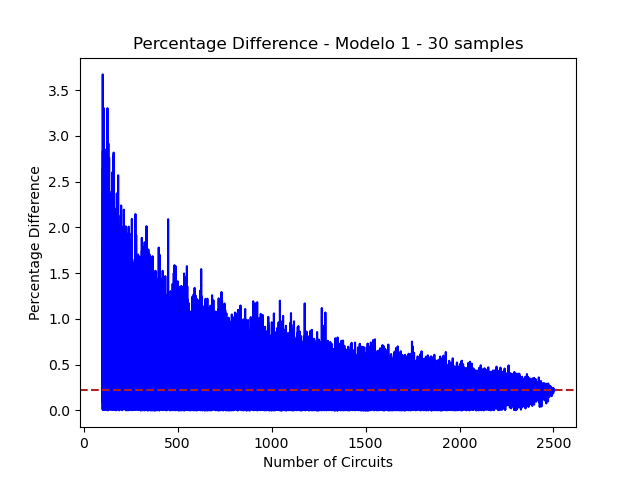

In [22]:
plt.figure()

for index, a in enumerate(percentage):

    plt.plot(dados_x, a, color = "b", label = f'{index}')

plt.axhline(y=0.221, color='firebrick', linestyle='--', label = '0.221%')
plt.xlabel('Number of Circuits')
plt.ylabel('Percentage Difference')
plt.title(f'Percentage Difference - Modelo {modelo} - 30 samples')
#plt.legend()
plt.show()

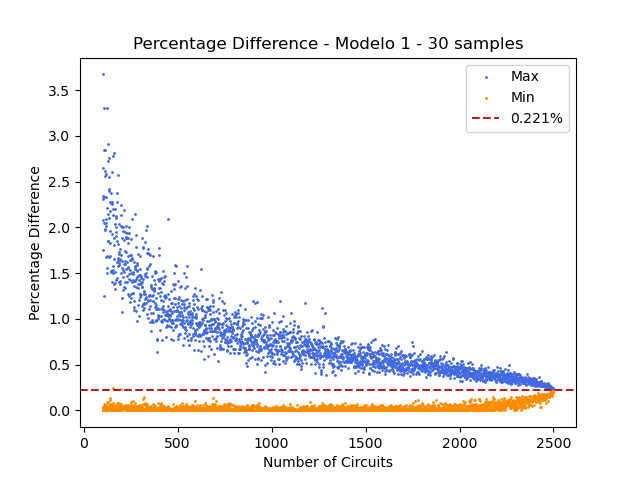

In [23]:
max_min_percentage = [[max(a), min(a)] for a in zip(*percentage)]

plt.figure()

plt.scatter(dados_x, list(a[0] for a in max_min_percentage), s=1, color = "royalblue", label = f'Max')
plt.scatter(dados_x, list(a[1] for a in max_min_percentage), s=1, color = "darkorange", label = f'Min')

plt.axhline(y=0.221, color='firebrick', linestyle='--', label = '0.221%')
plt.xlabel('Number of Circuits')
plt.ylabel('Percentage Difference')
plt.title(f'Percentage Difference - Modelo {modelo} - 30 samples')
plt.legend()
plt.show()



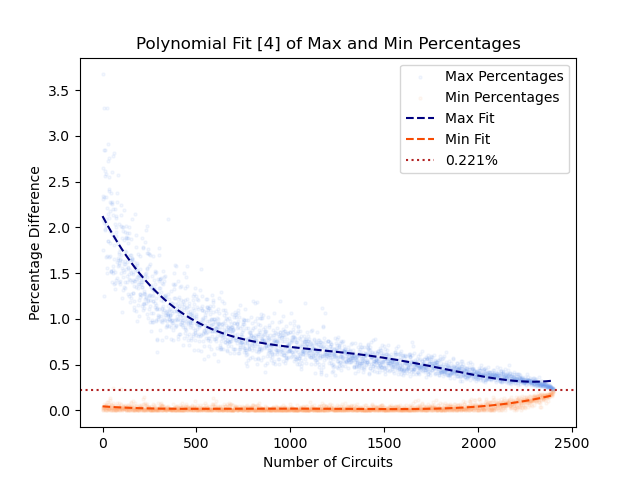

In [24]:
max_percentages, min_percentages = zip(*max_min_percentage)

max_percentages = np.array(max_percentages)
min_percentages = np.array(min_percentages)

coeffs_max = np.polyfit(range(len(max_percentages)), max_percentages, (degree := 4))
coeffs_min = np.polyfit(range(len(min_percentages)), min_percentages, degree)

poly_max = np.poly1d(coeffs_max)
poly_min = np.poly1d(coeffs_min)

x_values = np.arange(len(max_percentages))

y_max_fit = poly_max(x_values)
y_min_fit = poly_min(x_values)

plt.figure()

plt.scatter(x_values, max_percentages, s = (s := 5), alpha = (alpha := 0.07), color='cornflowerblue', label='Max Percentages')
plt.scatter(x_values, min_percentages, s = s, alpha = alpha, color='#fda468', label='Min Percentages')
plt.plot(x_values, y_max_fit, color='navy', linestyle='--', label='Max Fit')
plt.plot(x_values, y_min_fit, color='#f74b03', linestyle='--', label='Min Fit')

plt.xlabel('Number of Circuits')
plt.ylabel('Percentage Difference')
plt.axhline(y=0.221, color='firebrick', linestyle=':', label = '0.221%')
plt.title(f'Polynomial Fit [{degree}] of Max and Min Percentages')
plt.legend()
plt.show()


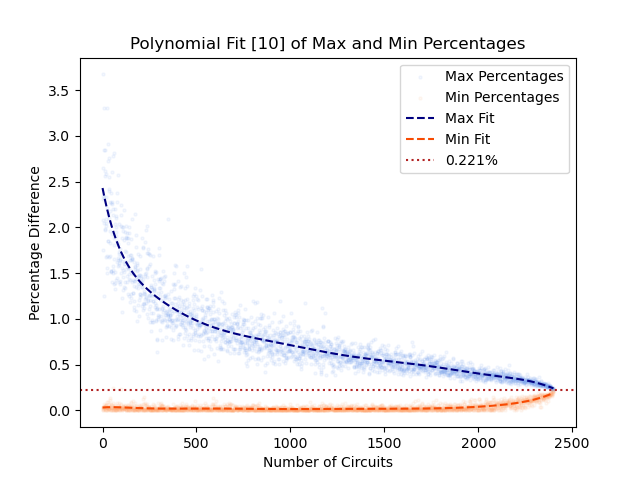

In [25]:
coeffs_max = np.polyfit(range(len(max_percentages)), max_percentages, (degree := 10))
coeffs_min = np.polyfit(range(len(min_percentages)), min_percentages, degree)

poly_max = np.poly1d(coeffs_max)
poly_min = np.poly1d(coeffs_min)

x_values = np.arange(len(max_percentages))

y_max_fit = poly_max(x_values)
y_min_fit = poly_min(x_values)

plt.figure()

plt.scatter(x_values, max_percentages, s = (s := 5), alpha = (alpha := 0.07), color='cornflowerblue', label='Max Percentages')
plt.scatter(x_values, min_percentages, s = s, alpha = alpha, color='#fda468', label='Min Percentages')
plt.plot(x_values, y_max_fit, color='navy', linestyle='--', label='Max Fit')
plt.plot(x_values, y_min_fit, color='#f74b03', linestyle='--', label='Min Fit')

plt.xlabel('Number of Circuits')
plt.ylabel('Percentage Difference')
plt.axhline(y=0.221, color='firebrick', linestyle=':', label = '0.221%')
plt.title(f'Polynomial Fit [{degree}] of Max and Min Percentages')
plt.legend()
plt.show()

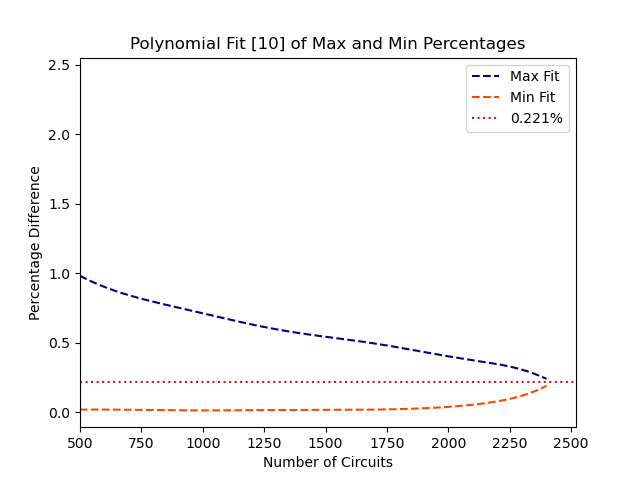

In [26]:
coeffs_max = np.polyfit(range(len(max_percentages)), max_percentages, (degree := 10))
coeffs_min = np.polyfit(range(len(min_percentages)), min_percentages, degree)

poly_max = np.poly1d(coeffs_max)
poly_min = np.poly1d(coeffs_min)

x_values = np.arange(len(max_percentages))

y_max_fit = poly_max(x_values)
y_min_fit = poly_min(x_values)

plt.figure()

#plt.scatter(x_values, max_percentages, s = (s := 5), alpha = (alpha := 0.07), color='cornflowerblue', label='Max Percentages')
#plt.scatter(x_values, min_percentages, s = s, alpha = alpha, color='#fda468', label='Min Percentages')
plt.plot(x_values, y_max_fit, color='navy', linestyle='--', label='Max Fit')
plt.plot(x_values, y_min_fit, color='#f74b03', linestyle='--', label='Min Fit')

plt.xlabel('Number of Circuits')
plt.xlim(left = 500)
plt.ylabel('Percentage Difference')
plt.axhline(y=0.221, color='firebrick', linestyle=':', label = '0.221%')
plt.title(f'Polynomial Fit [{degree}] of Max and Min Percentages')
plt.legend()
plt.show()

In [27]:
len(percentage)

29

In [28]:
len(np.random.rand(2501, 30))

2501

Menor N: 895


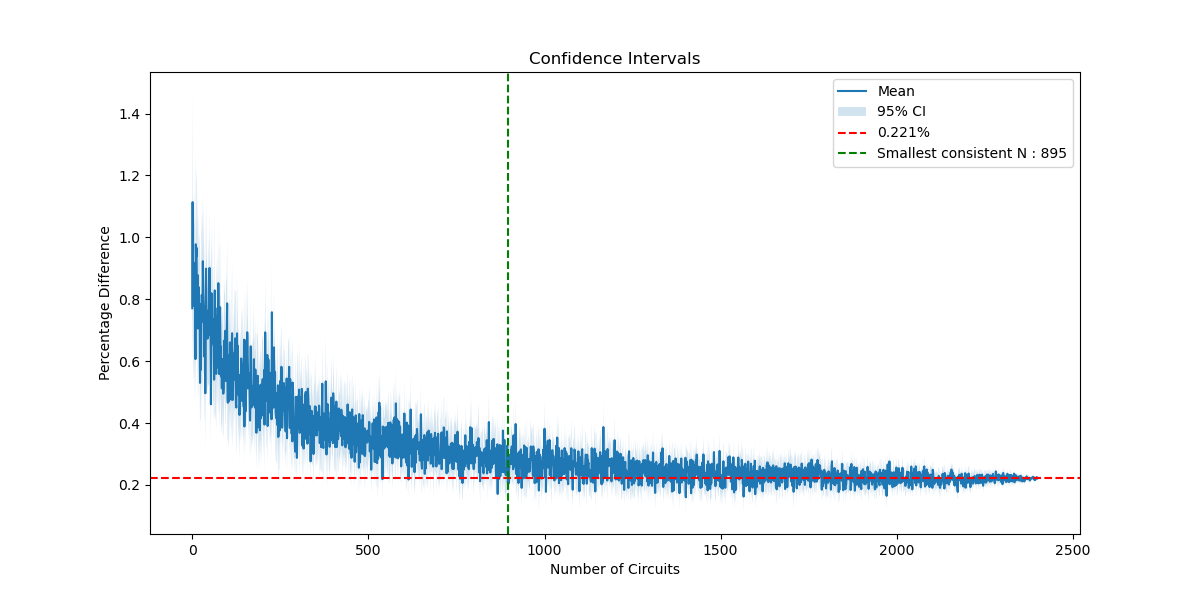

In [29]:
data =  [list(group) for group in zip(*percentage)]
result_2500 = 0.221

def confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    se = stats.sem(data)
    ci = stats.t.interval(confidence, len(data)-1, loc=mean, scale=se)
    return ci


smallest_N = None
consistent_count = 0
required_consistency = 10  

for N in range(len(data)):
    ci = confidence_interval(data[N])
    
    if ci[0] <= result_2500 <= ci[1]:
        if smallest_N is None:
            smallest_N = N
        consistent_count += 1
        if consistent_count >= required_consistency:
            break
    else:
        smallest_N = None
        consistent_count = 0

if smallest_N is not None:
    print(f"Menor N: {smallest_N}")
else:
    print("F total")

plt.figure(figsize=(12, 6))
plt.plot(range(len(data)), [np.mean(row) for row in data], label='Mean')
plt.fill_between(range(len(data)), 
                 [confidence_interval(row)[0] for row in data],
                 [confidence_interval(row)[1] for row in data],
                 alpha=0.2, label='95% CI')
plt.axhline(y=result_2500, color='r', linestyle='--', label='0.221%')
if smallest_N is not None:
    plt.axvline(x=smallest_N, color='g', linestyle='--', label=f'Smallest consistent N : {smallest_N}')
plt.xlabel('Number of Circuits')
plt.ylabel('Percentage Difference')
plt.title('Confidence Intervals')
plt.legend()
plt.show()  

# 1500 Shots + 895 Circuits

## 40275.0

In [30]:
print(1500*895*0.03)

40275.0
